# Домашнее задание
## Реализация алгоритма Deep Feature Interpolation

### План

1. Изучите алгоритм, описанный в [статье](https://arxiv.org/pdf/1611.05507.pdf).
2. Скачайте датасет (`faces.tar`) и разархивируйте его.
3. Реализуйте алгоритм **Deep Feature Interpolation**.
4. Продемонстрируйте результаты работы на произвольном изображении.

### Критерии оценки

* реализация базового алгоритма (с демонстрацией работы на каком-нибудь изображении из выборки): **50 баллов**
* визуализация интерполяции (варьировать степень модификации изменением $\alpha$): **30 баллов**
* применить алгоритм к какой-нибудь картике не из выборки (с применением детектора и вставкой обратно): **20 баллов**

### Подсказки

* для экономии памяти предлагается хранить в индексе не сами вектора, а их проекции на меньшее пространство (например, в качестве базиса использовать top-256 PCA, посчитанный на 5К-10К объектах выборки), а когда нужно посчитать вектор-смещение, просто пересчитывать необходимое количество
* поэкспериментируйте со взвешиванием основного лосса и полной вариации
* экспериментируйте на изображениях меньшего разрешения (например, 64х64)

In [2]:
from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = 128
USE_CUDA = True

In [3]:
!nvidia-smi

Tue Apr 23 01:18:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   41C    P2    63W / 250W |   9912MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   33C    P8    15W / 250W |    894MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
DEVICE_ID = 1
DEVICE = torch.device(('cuda:%d' % DEVICE_ID) if torch.cuda.is_available() and USE_CUDA else 'cpu')
torch.cuda.set_device(DEVICE_ID)

### Загрузка данных

*Предоставляемый датасет был размечен классификатором, поэтому может содержать большое количество ошибок. Тем не менее, для выполнения данного задания это не так критично.*

In [5]:
def load_dataset(directory):
    header = []
    labels = []
    filepaths = []
    
    with open(os.path.join(directory, 'gt.csv')) as f:
        header = f.readline().strip().split()[1:]
        header = [h.lower() for h in header]
        for line in f:
            fields = line.strip().split()
            path = os.path.join(directory, fields[0])
            filepaths.append(path)
            labels.append(fields[1:])

    return (
        header,
        np.array(labels),
        np.array(filepaths)
    )

DATASET_DIRECTORY_PATH = './data/faces'  
header, labels, filepaths = load_dataset(DATASET_DIRECTORY_PATH)

print(f"{len(filepaths)} изображений в датасете")

202278 изображений в датасете


In [6]:
print("Содержимое датасета по категориям:")
for i in range(len(header)):
    print(header[i], ":")
    names, counts = np.unique(labels[:, i], return_counts=True)
    for j in range(len(names)):
        print(" * ", names[j], ":", counts[j])

Содержимое датасета по категориям:
race :
 *  asian : 16215
 *  caucasian : 186063
gender :
 *  female : 134736
 *  male : 67542
age :
 *  adult : 75318
 *  old : 62429
 *  senior : 43973
 *  young : 20558
facial_hair :
 *  beard : 6689
 *  mustache : 2541
 *  shaved : 193048


In [7]:
# функция для удобного взаимодействия с разметкой

def get_mask(**kwargs):
    mask = np.ones(len(filepaths), dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels[:, header.index(h)], kwargs[h])
        else:
            mask &= labels[:, header.index(h)] == kwargs[h]
    return mask

def load_image(path, size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.convert("RGB")
    img = img.resize(size, Image.BICUBIC)
    return img


def backup_numpy(arr, filename):
    BACKUP_PATH = "data/backup/"
    np.save(BACKUP_PATH + filename, arr)

def load_backup(filename):
    BACKUP_PATH = "data/backup/"
    return np.load(BACKUP_PATH + filename)

# примеры запросов
print("count(asian & female) =", get_mask(race='asian', gender='female').sum())
print("count(caucasian & male & shaved) =", get_mask(race='caucasian', gender='male', facial_hair='shaved').sum())

count(asian & female) = 11046
count(caucasian & male & shaved) = 53359


### Функция $\phi(x)$

Определим функцию отображения в признаковое пространство в виде `nn.Module`:


In [8]:
class Phi(nn.Module):
    def __init__(self, pretrained=True):
        super(Phi, self).__init__()

        model = torchvision.models.vgg19(pretrained=pretrained)
        
        layers = list(model.features)
        self.slice_0 = nn.Sequential(*layers[0:12])
        self.slice_1 = nn.Sequential(*layers[12:21])
        self.slice_2 = nn.Sequential(*layers[21:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = (x - mean) / std
        
        xs = []

        x = self.slice_0(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_1(x)
        xs.append(x.view(x.shape[0], -1))
        
        x = self.slice_2(x)
        xs.append(x.view(x.shape[0], -1))
        
        #return np.concatenate(xs, axis=1)
        return torch.cat(xs, 1)
    

to_tensor = torchvision.transforms.ToTensor()
to_image = torchvision.transforms.ToPILImage()

phi = Phi().eval()

number of features per image:  425984


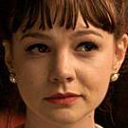

In [9]:
# пример использования

image = load_image(filepaths[0])
fx = phi(to_tensor(image).unsqueeze(0))[0]

print("number of features per image: ", fx.shape[0])
image

### Построение индекса базы

Извлеките признаки (функцией $\phi$) из изображений базы. По этим признакам вы будете искать похожие изображения, поэтому можно хранить их сжатое представление.

In [10]:
BLOCK_SIZE = 5000
TOTAL_LEN  = len(filepaths)

In [11]:
def get_image_batch(indexes, use_tqdm=False):
    image_batch = []
    
    if use_tqdm:
        indexes = tqdm(indexes)
        
    for i in indexes:
        image = load_image(filepaths[i])
        image_tensor = to_tensor(image).unsqueeze(0)
        image_batch.append(image_tensor)
    return torch.cat(image_batch, 0)

In [12]:
%%time
image_batch = get_image_batch(range(0, BLOCK_SIZE), True)
train_features = phi(image_batch)


CPU times: user 40min, sys: 4min 55s, total: 44min 55s
Wall time: 9min 4s


In [13]:
%%time
pca = PCA(n_components=250)
pca.fit(train_features.detach().numpy())

CPU times: user 13min, sys: 1min 52s, total: 14min 52s
Wall time: 3min 45s


In [14]:
LAST_EPOCH = 40
if LAST_EPOCH == -1:
    features = None
else:
    assert(LAST_EPOCH >= 0)
    features = load_backup("features_epoch_{}.npy".format(LAST_EPOCH))

for epoch in tqdm(range(LAST_EPOCH+1, 1 + TOTAL_LEN // BLOCK_SIZE)):
    ranges = range(epoch * BLOCK_SIZE, min((epoch + 1) * BLOCK_SIZE, TOTAL_LEN))
    
    image_batch = get_image_batch(ranges)
    fx_batch = phi(image_batch)
    pca_batch = pca.transform(fx_batch.numpy())
    if features is None:
        features = pca_batch
    else:
        features = np.vstack((features, pca_batch))
    backup_numpy(features, "features_epoch_{}".format(epoch))

### Функция подбора кандидатов

У нас есть база признаков, по которым мы можем искать изображения, похожие на запрос. Напишите функцию, которая для данного изображения `query` находит `n` наиболее похожих на него (по сжатому признаковому описанию) среди изображений, покрываемых бинарной маской `mask` (размер маски равен количеству изображений в базе). В качестве меры похожести можете использовать косинусную меру.

In [23]:
def best_similar(query_image, mask, n=100):
    fx = phi(to_tensor(query_image).unsqueeze(0)).numpy()
    feature_vector = pca.transform(fx).reshape(1, -1)
    
    distances = cosine_similarity(feature_vector, features[mask]).ravel()
    similar = (np.argsort(distances)[::-1])[:n]
    return np.nonzero(mask)[0][similar]

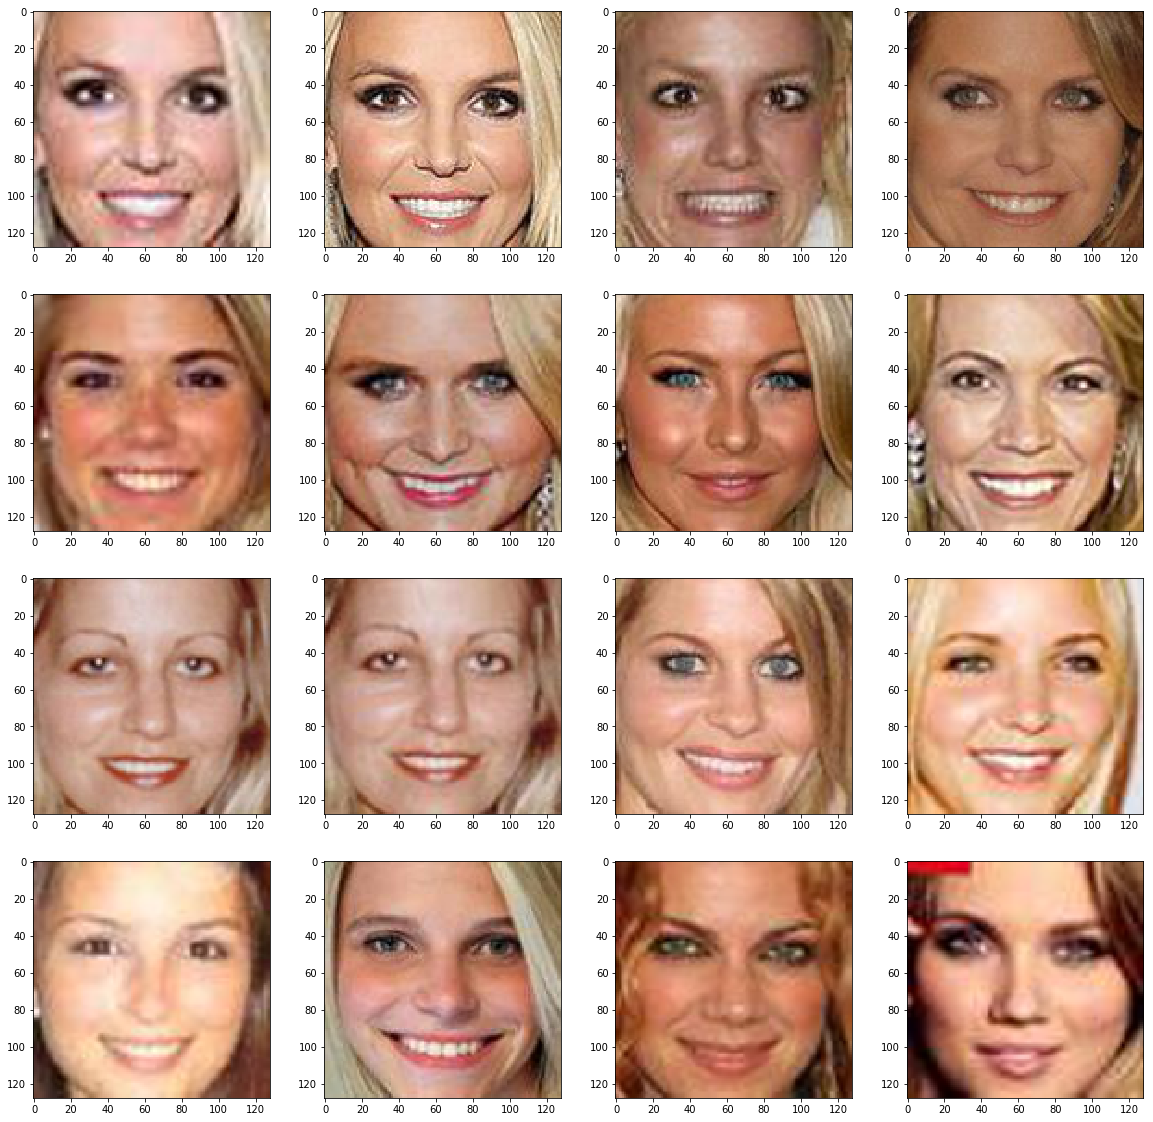

In [25]:
def print_similar(query_image):
    indexes = best_similar(query_image, get_mask(race='caucasian', gender='female'))
    _, axes = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(4):
        for j in range(4):
            image = load_image(filepaths[indexes[i * 4 + j]])
            axes[i, j].imshow(image)

print_similar(load_image(filepaths[4]))

### Вычисление центров кластеров

Используя функцию `best_similar` реализуйте функцию подсчёта центров кластеров в признаковом пространстве $\phi$ изображений, наиболее похожих на изображение-запрос. С использованием этой функции вы сможете для двух различных наборов атрибутов (например `caucasian & male` и `asian & male`) вычислить вектор-смещение, по которому мы будем "двигать" признаковое описание оптимизируемого изображения. 

*Заметьте, что если мы будем производить модификацию из `caucasian & male` в `asian & male`, то изображение, которое мы оптимизируем, должно принадлежать множеству `caucasian & male`, иначе результат может получиться так себе.*

In [26]:
def class_centre(query_image, mask):
    similar_ind = best_similar(query_image, mask)
    image_batch = get_image_batch(similar_ind)
    features_batch = phi(image_batch)
    return torch.mean(features_batch, dim=0)

### Функция потерь

Реализуйте функцию потерь, которую мы будем минимизировать для выбранного изображения и вычисленного для него вектора смещения.

In [27]:
class TVLoss(nn.Module):
    def __init__(self, eps=1e-3, beta=2):
        super(TVLoss, self).__init__()
        self.eps = eps
        self.beta = beta

    def forward(self, input):
        x_diff = input[:, :, :-1, :-1] - input[:, :, :-1, 1:]
        y_diff = input[:, :, :-1, :-1] - input[:, :, 1:, :-1]

        sq_diff = torch.clamp(x_diff * x_diff + y_diff * y_diff, self.eps, 10000000)
        return torch.norm(sq_diff, self.beta / 2.0) ** (self.beta / 2.0)


def Loss(target_features, image_tensor):
    current_features = phi.forward(image_tensor)
    
    criterion1 = nn.MSELoss(size_average = False).cuda()
    criterion2 = TVLoss().cuda()
    return  0.5 * criterion1(current_features, target_features) + 0.05 * criterion2(image_tensor)

### Оптимизиация

Напишите код оптимизиации изображения с использованием какого-нибудь оптимизатора.

In [28]:
def inverse(target_features, image_tensor):
    image_tensor = image_tensor.cuda()
    target_features = target_features.cuda()
    phi.cuda()
    opt_image = image_tensor.clone().requires_grad_()
    
    optimizer = torch.optim.LBFGS(
      params = [opt_image],
      max_iter = 500,
    )

    def closure():
        optimizer.zero_grad()

        loss = Loss(target_features, opt_image)
        loss.backward()
        return loss

    optimizer.step(closure)
    
    target_features.cpu()
    phi.cpu()
    result_image = opt_image.detach().cpu()
    return result_image

In [33]:
def run_experiment(image,
                   mask_from,
                   mask_to,
                   alpha=4):
    phi.cpu()
    features_from = class_centre(image, mask_from)
    features_to   = class_centre(image, mask_to)
    w = features_to - features_from
    
    image_tensor = to_tensor(image).unsqueeze(0)
    curr_features = phi(image_tensor)[0]
    target_features = curr_features + alpha * w
    
    res_tensor = inverse(target_features, image_tensor)
    trash = inverse(curr_features, image_tensor)
    
    # Устранение артефактов
    res_image = (res_tensor + (image_tensor - trash)).data.clamp_(0, 1)
    return to_image(res_image[0])

In [143]:
def set_beard(image, **options):
    res_image = run_experiment(image,
                           get_mask(gender='male', facial_hair='shaved'),
                           get_mask(gender='male', facial_hair='beard'), **options)
    return res_image

def set_male(image, **options):
    res_image = run_experiment(image,
                           get_mask(gender='female', race='caucasian'),
                           get_mask(gender='male', race='caucasian'), **options)
    return res_image

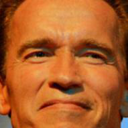

In [150]:
image = load_image(filepaths[3])
image

/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


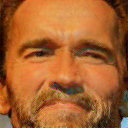

In [151]:
set_beard(image, alpha=3)

### Устранение артефактов (желательно)

В результате оптимизации на изображении могут появиться нежелательные артифакты в виде смещения цетовой палитры. Попробуйте побороть это вычитанием из результата разницы между исходным изображением и модифицированным изображением с параметром $\alpha=0$.

/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


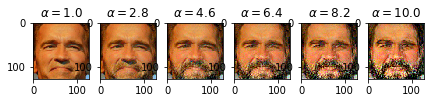

In [200]:
N_tests = 5
alphas = np.linspace(1, 10, N_tests)
image = load_image(filepaths[3])
_, axes = plt.subplots(1, N_tests, figsize=(14, 24))
for i, alpha in tqdm(enumerate(alphas))t:
    res_image = set_beard(image, alpha=alpha)
    axes[i].imshow(res_image)
    axes[i].set_title("$\\alpha=$" + str(alpha))

### Работа с изображениями не из базы (бонус)

Ниже приведена функция `get_face_bbox`, которая возращает координаты для кропа лица из изображения. Используйте её, чтобы вырезать изображение лица, произвести над ним какую-нибудь трансформацию (например, смена пола или расы), а затем вставить модифицированное изображение обратно.

In [122]:
import cv2
from PIL import Image
import requests
from io import BytesIO


HAAR_CASCADE_FILEPATH = './data/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILEPATH)

def get_face_bbox(image):
    faces = cascade.detectMultiScale(
        np.asarray(image),
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(50, 50),
        flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    scale_factor = 0
    return x - scale_factor * w,  \
            y - scale_factor * w, \
           x + (1 + scale_factor) * w, \
           y + (1 + scale_factor) * h  \

initial image size = (660, 535)
image size after resize = (631, 512)


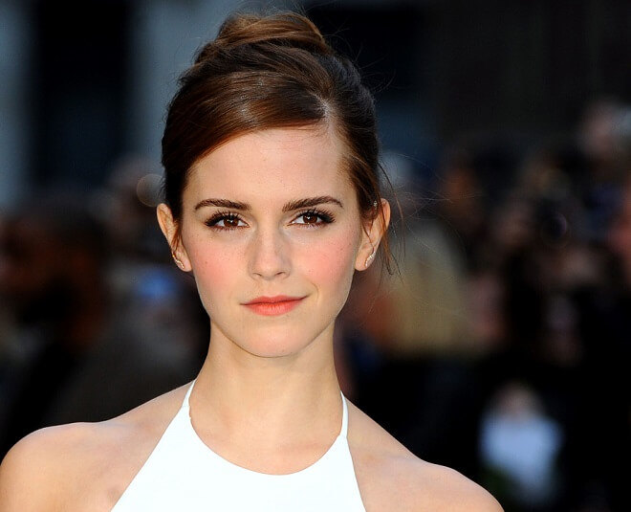

In [140]:
url = "https://images4.yesmagazine.ru/upload/cache_img/7b6/7b678ebc40ca96bf961f5059ba16aeef_fitted_660x880.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
print("initial image size = " + str(img.size))
img = torchvision.transforms.Resize(512)(img)
print("image size after resize = " + str(img.size))
x0, y0, x1, y1 =  get_face_bbox(img)
img

initial face size = (222, 222)


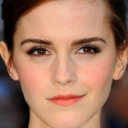

In [142]:
face = img.crop((x0, y0, x1, y1))
initial_size = face.size
print("initial face size = " + str(face.size))
image = torchvision.transforms.Resize(128)(face)
image

/home/alexey.kozinov/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


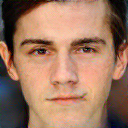

In [145]:
new_image = set_male(image, alpha=3)
new_image

In [146]:
new_face = torchvision.transforms.Resize(initial_size[0])(new_image)

In [152]:
new_img = img.copy()
new_img.paste(new_face, (x0, y0))

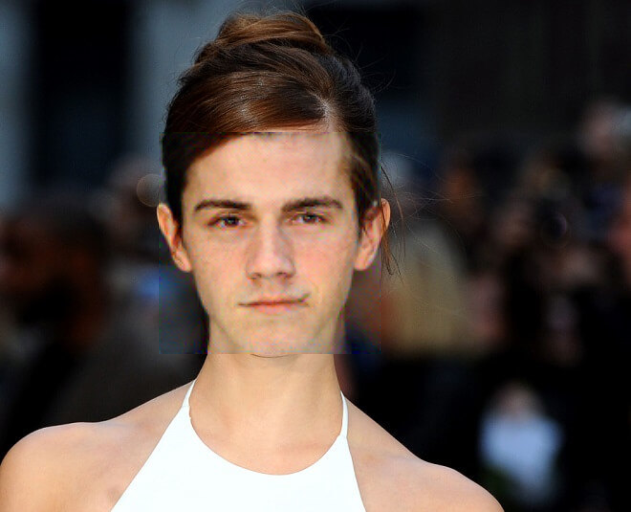

In [153]:
new_img